In [1]:
import plaidml.keras

plaidml.keras.install_backend()
import plaidml.keras.backend

In [2]:
import datetime
import tensorflow as tf
from keras import datasets, callbacks
from keras import utils
from keras import layers, optimizers, Sequential
from keras.layers import Conv2D,Activation,MaxPooling2D,Dropout,Flatten,Dense
import numpy as np
import matplotlib.pyplot as plt
import ssl
import cv2
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
class SimpleGrapher(callbacks.Callback):    
    def __init__(self, metrics):
        self.names = []
        self.data = {}
        self.modelIndex = -1
        for metric in metrics:
            self.data[metric] = []
        
    
    def new_model(self, name):
        self.names.append(name)
        for metric in self.data:
            self.data[metric].append([])
        self.modelIndex += 1
    
    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        for metric in self.data:
            self.data[metric][self.modelIndex].append(logs[metric])

    def show_graph(self, metric):
        for i in range(self.modelIndex+1):
            plt.plot(self.data[metric][i], label=self.names[i])            
        plt.legend()
        plt.show()

In [4]:
X = np.load("X.npy").astype(np.float32)
Y = np.load("Y.npy").astype(np.float32)

In [24]:
def CNN_classification_model(input_size = X.shape[1:], num_classes = 3):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',
    input_shape=input_size))
    model.add(Activation('relu'))
    #Conv2
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),strides =1))
#     # The second module
#     model.add(Conv2D(64, (3, 3), padding='same'))
#     model.add(Activation('relu'))
#     model.add(Conv2D(64, (3, 3)))
#     model.add(Activation('relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
    # Perform flattening before connecting to the fully connected network.
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    # The dropout layer parameter value ranges from 0 to 1.
    model.add(Dropout(0.25))
    model.add(Dense(units=num_classes))
    model.add(Activation('softmax'))
    
    opt = optimizers.Adam(lr=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [25]:
callbacker = SimpleGrapher(["loss", "acc", "val_loss", "val_acc"])
callbacker.new_model("testModel")

model = CNN_classification_model()
model.summary()
model.fit(X,Y, batch_size=32, epochs=10, verbose=1, validation_split=0.10, callbacks=[callbacker])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
activation_35 (Activation)   (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 126, 126, 32)      9248      
_________________________________________________________________
activation_36 (Activation)   (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 125, 125, 32)      0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 500000)            0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               64000128  
__________

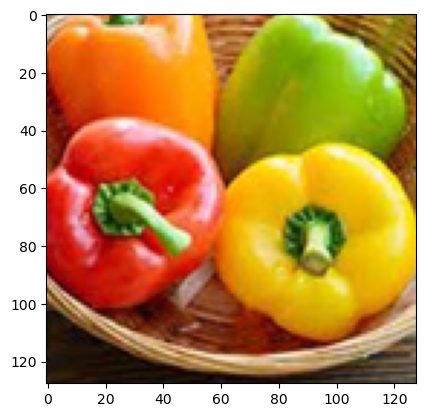

[[6.6304236e-04 9.9933690e-01]]


'cap'

In [120]:
imgTest = cv2.imread("images\\capcicum11.jpg")
imgTest = cv2.resize(imgTest, (128, 128))
imgTest = cv2.cvtColor(imgTest, cv2.COLOR_BGR2RGB)

#imgTest = X[13] * 255.0
plt.imshow(imgTest)
plt.show()
imgTest = np.array(imgTest).reshape(1, 128, 128, 3)
imgTest = imgTest/255.0

label = ["donut", "cap"]

print(model.predict(imgTest))
label[np.argmax(model.predict(imgTest))]

In [106]:
model.export("models/savedModel.h5")

AttributeError: 'Sequential' object has no attribute 'export'

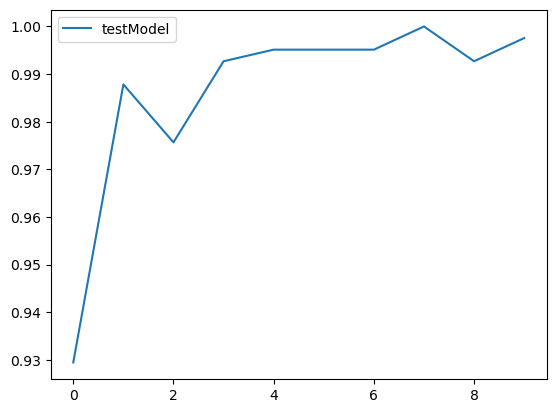

In [121]:
callbacker.show_graph("val_acc")